# Sprint14課題 ディープラーニングフレームワーク1

## 1.この課題の目的

- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

## 2.コードリーディング
TensorFLowによって2値分類を行うサンプルコードををベースに進める。

tf.kerasやtf.estimatorなどの高レベルAPIは使用せず、低レベルから見ていく。

## 【問題1】スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙する。

### ディープラーニングの実装に必要な準備

1. データセットを用意する（データ型、shape）


2. 目的関数（損失）を定義する（問題の種類（分類、回帰）で異なることに注意）


3. ネットワークの以下クラスで誤差順伝播法、誤差逆伝播法のメソッドを定義）
    - レイヤー：全結合層、畳み込み層、プーリング層
    - 活性化関数：Sigmoid, Hyperbolic Tangent, ReLU


4. 各レイヤーのクラスを作成する際は、引数として以下のクラスを入れる
    - パラメータ初期値設定のアルゴリズム：SimpleInitializer, XavierInitializer, HeInitializer
    - パラメータ更新（学習）のアルゴリズム：SGD、AdaGrad

## 【問題2】スクラッチとTensorFlowの対応を考える

問題１で列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認し、簡単に言葉でまとめること。
単純な一対一の対応であるとは限らない。

### スクラッチ実装とフレームワーク（TensorFlow）の対応関係

1. 変数、パラメータの定義
    - tf.placeholder() : 入出力を定義する。引数で「データ数、shape」を指定
    - tf.Variable() : パラメータを定義する。


2. 目的関数の定義
    - 目的関数（loss_function）は、tf.nn. + 関数名（例：sigmoid_cross_entropy_with_logits）で定義
    - 目的関数は学習時、学習後のロスの計算の２箇所で使用する。
    - 学習時はtf.reduce_mean(loss_function)、学習後の計算ではsess.run(loss_function, feed_dict = {X:, y:})となる。


3. ニューラルネットワークの定義
    - 各レイヤーのインスタンス：tf.add()を用いて（計算グラフとして）定義する
    - 活性化関数のインスタンス：tf.nn. + 活性化関数で定義する


4. メソッド（fit, predict）の確認
    - sess.run(train_op, dict_feed{X: X_train, Y: y_train})
    - train_opが学習のメソッド(スクラッチ実装での.fit)を表現している。具体的には、optimizerのインスタンスが損失関数の最小化（.minimize(loss_function))を実行する。



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

from tqdm import tqdm_notebook as tqdm

### 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

[Iris Species](https://www.kaggle.com/uciml/iris/data)

サンプルコードと同じくこの中のtrain.csvを使用する。（目的変数はSpeciesに含まれる3種類全てを使う）

2クラスの分類と3クラス以上の分類の違いを考慮すること。

それが、TensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べること。

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

import tensorflow as tf

In [3]:
# データセットの準備
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)

# 多値分類なので、条件抽出は行わない
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = df["Species"]
X = np.array(X)
y = np.array(y)

# ラベル値を数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

In [4]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [5]:
# one hot encoding
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_test = enc.fit(y_test).transform(y_test)
y_train = enc.fit(y_train).transform(y_train)
y_val = enc.fit(y_val).transform(y_val)

In [6]:
y_train.shape

(96, 3)

In [7]:
# データの不均衡度を確認
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([192,  96]))

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [9]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 100

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

In [10]:
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
print(X)
print(Y)

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

Tensor("Placeholder:0", shape=(?, 4), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)


In [11]:
def example_net(x):
    """
    単純な３層ニューラルネットワーク
    """
    
    # 重みとバイアスの宣言
    weights = {
        "w1": tf.Variable(tf.random_normal([n_input, n_hidden1])),
        "w2": tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        "w3": tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    
    biases = {
        "b1": tf.Variable(tf.random_normal([n_hidden1])),
        "b2": tf.Variable(tf.random_normal([n_hidden2])),
        "b3": tf.Variable(tf.random_normal([n_classes]))
    }
    
    layer_1 = tf.add(tf.matmul(x, weights["w1"]), biases["b1"]) # 加算レイヤー
    layer_1 = tf.nn.relu(layer_1) # 活性化（ReLU）
    layer_2 = tf.add(tf.matmul(layer_1, weights["w2"]), biases["b2"]) # 加算レイヤー
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights["w3"]) + biases["b3"]
    
    return layer_output

In [12]:
# ネットワーク構造の読み込み
logits = example_net(X)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
pred = tf.argmax(tf.nn.softmax(logits), axis=1)
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(tf.nn.softmax(logits), axis=1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i , (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        #print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    y_pred = sess.run(pred, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}\n".format(test_acc))
    
    classified = sess.run(pred, feed_dict={
        X:X_train,
        Y:y_train
    })
    
    print("Predicted classes for train data.")
    print(classified)

test_acc : 1.000

Predicted classes for train data.
[1 0 2 0 2 2 1 0 2 0 2 2 0 0 2 2 0 2 0 0 2 2 1 0 2 0 2 1 2 1 2 0 1 2 1 2 0
 2 0 1 2 1 0 2 1 1 2 1 1 0 1 0 0 2 2 2 0 1 2 2 1 1 2 2 1 0 0 1 1 1 0 2 2 0
 1 2 0 0 2 0 2 2 0 0 1 1 2 0 1 1 0 0 2 1 1 1]


#### 結果の可視化

In [15]:
# one-hot ラベルをmulti-labelへ戻す
y_true = []

for i in range(len(y_test)):
    y_true.append(int(np.where(y_test[i] == 1)[0]))

results = pd.DataFrame(y_true, columns=["true"])
results["pred"] = y_pred

- 1件（index：21）のみクラス1をクラス２に誤分類しているが、その他は全て正解と予測が一致している。

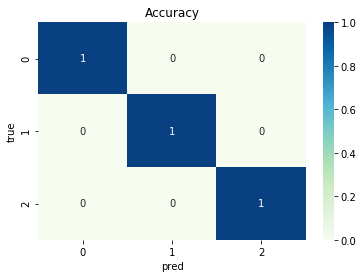

In [16]:
# ラベルの生成
labels = np.unique(y_true)
    
# 混同行列を生成
cmx = confusion_matrix(y_true, y_pred, labels=labels)
df = pd.DataFrame(cmx, index=labels, columns=labels)

# 正解率（accuracy）に変換
df = df.apply(lambda x: round(x/sum(x), 2), axis=1)

# ヒートマップによる混同行列の可視化
sns.heatmap(df, annot=True, cmap="GnBu")
plt.xlabel("pred")
plt.ylabel("true")
plt.title("Accuracy")
plt.show()

## 【問題4】House Pricesのモデルを作成

回帰問題のデータセットであるHouse Pricesを使用したモデルを作成する。

[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

この中のtrain.csvをダウンロードし、目的変数として[SalePrice]、説明変数として[GrLivArea, YearBuilt]を使うこと。
（説明変数はさらに増やしても構わない）

分類問題と回帰問題の違いを考慮すること。

In [17]:
def example_net_HP(x):
    """
    単純な３層ニューラルネットワーク
    """
    
    # 重みとバイアスの宣言
    weights = {
        "w1": tf.Variable(tf.random_normal([n_input_HP, n_hidden1_HP])),
        "w2": tf.Variable(tf.random_normal([n_hidden1_HP, n_hidden2_HP])),
        "w3": tf.Variable(tf.random_normal([n_hidden2_HP, n_classes_HP]))
    }
    
    biases = {
        "b1": tf.Variable(tf.random_normal([n_hidden1_HP])),
        "b2": tf.Variable(tf.random_normal([n_hidden2_HP])),
        "b3": tf.Variable(tf.random_normal([n_classes_HP]))
    }
    
    layer_1 = tf.add(tf.matmul(x, weights["w1"]), biases["b1"]) # 加算レイヤー
    layer_1 = tf.nn.relu(layer_1) # 活性化（ReLU）
    layer_2 = tf.add(tf.matmul(layer_1, weights["w2"]), biases["b2"]) # 加算レイヤー
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights["w3"]) + biases["b3"]
    
    return layer_output

In [18]:
# データセットの準備
df_train_HP = pd.read_csv("train.csv")
df_test_HP = pd.read_csv("test.csv")

# 説明変数
X_HP = df_train_HP[["GrLivArea", "YearBuilt"]].values
X_HP_test = df_test_HP[["GrLivArea", "YearBuilt"]].values

# 目的変数
y_HP = df_train_HP["SalePrice"].values[:, np.newaxis]

In [19]:
# データセットを学習用、検証用に分割
X_train_HP, X_val_HP, y_train_HP, y_val_HP = train_test_split(X_HP, y_HP, test_size=0.2, random_state=0)

In [20]:
# 説明変数を平準化
ss = StandardScaler()
X_train_std_HP = ss.fit_transform(X_train_HP)
X_val_std_HP = ss.fit_transform(X_val_HP)
X_test_std_HP = ss.fit_transform(X_HP_test)

/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Use

In [21]:
# ハイパーパラメータの設定
learning_rate_HP = 0.5
batch_size_HP = 30
num_epochs_HP = 200

n_hidden1_HP = 50
n_hidden2_HP = 100
n_input_HP = X_train_std_HP.shape[1]
n_samples_HP = X_train_std_HP.shape[0]
n_classes_HP = 1

In [22]:
# 計算グラフに渡す引数の形を決める
X_HP = tf.placeholder("float", [None, n_input_HP])
Y_HP = tf.placeholder("float", [None, n_classes_HP])
print(X_HP)
print(Y_HP)

# trainのミニバッチイテレータ
get_mini_batch_train_HP = GetMiniBatch(X_train_std_HP, y_train_HP, batch_size=batch_size_HP)

Tensor("Placeholder_2:0", shape=(?, 2), dtype=float32)
Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [23]:
# ネットワーク構造の読み込み
logits_HP = example_net_HP(X_HP)

# 目的関数
loss_op_HP = tf.losses.mean_squared_error(labels=Y_HP, predictions=logits_HP)

# 最適化手法
optimizer_HP = tf.train.AdamOptimizer(learning_rate=learning_rate_HP)
train_op_HP = optimizer_HP.minimize(loss_op_HP)

# 推定結果（線形問題）
pred_HP = logits_HP

Instructions for updating:
Use tf.cast instead.


In [24]:
# variableの初期化
init_HP = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init_HP)
    
    for epoch in range(num_epochs_HP):
        total_batch = np.ceil(X_train_HP.shape[0]/batch_size).astype(np.int)
        
        for i , (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train_HP):
            
            sess.run(train_op_HP, feed_dict={X_HP: mini_batch_x, Y_HP: mini_batch_y})
            
            loss = sess.run(loss_op_HP, feed_dict={X_HP: mini_batch_x, Y_HP: mini_batch_y})
            total_loss += loss        
    
    y_train_pred = sess.run(pred_HP, feed_dict={X_HP: X_train_std_HP}) # 予測
    train_r2 = r2_score(y_train_HP, y_train_pred) # 決定係数
    print("Coefficient of determination for train data : {:.2f}".format(train_r2))
    
    y_val_pred = sess.run(pred_HP, feed_dict={X_HP: X_val_std_HP}) # 予測
    val_r2 = r2_score(y_val_HP, y_val_pred) # 決定係数
    print("Coefficient of determination for validation data : {:.2f}\n".format(val_r2))
    
    y_test_pred = sess.run(pred_HP, feed_dict={
        X_HP:X_test_std_HP,
    })
    #print("y_test_pred", y_test_pred)

Coefficient of determination for train data : 0.72
Coefficient of determination for validation data : 0.60



#### 結果の可視化

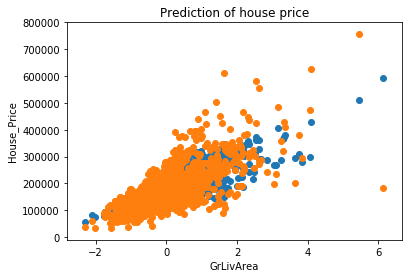

In [25]:
# 説明変数：GrLiveArea、目的変数：House Price
plt.scatter(X_train_std_HP[:,0], y_train_pred)
plt.scatter(X_train_std_HP[:,0], y_train_HP)
plt.xlabel("GrLivArea")
plt.ylabel("House_Price")
plt.title("Prediction of house price")
plt.show()

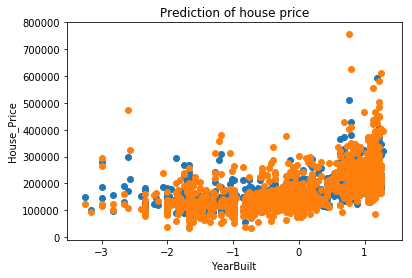

In [26]:
# 説明変数：YearBuilt、目的変数：House Price
plt.scatter(X_train_std_HP[:,1], y_train_pred)
plt.scatter(X_train_std_HP[:,1], y_train_HP)
plt.xlabel("YearBuilt")
plt.ylabel("House_Price")
plt.title("Prediction of house price")
plt.show()

- 決定係数がtrain dataで0.72、validation dataで0.59とモデルの予測精度は高くないが、回帰分析自体は正しく行われている。

## 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成する。

3クラス以上の分類という点ではひとつ前のIrisと同様だが、入力が画像であるという点で異なる。

スクラッチで実装したモデルの再現を目指すこと。

In [27]:
from keras.datasets import mnist

Using TensorFlow backend.


In [28]:
(X_train_MN, y_train_MN), (X_test_MN, y_test_MN) = mnist.load_data()

In [29]:
# 正規化
X_train_MN = X_train_MN / np.max(X_train_MN)
X_test_MN = X_test_MN / np.max(X_test_MN)

In [30]:
X_train_MN = X_train_MN.reshape(-1,  784)
X_test_MN = X_test_MN.reshape(-1,  784)

In [31]:
# one hot encoding
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_MN_onehot = enc.fit(y_train_MN[:, np.newaxis]).transform(y_train_MN[:, np.newaxis])
y_test_MN_onehot = enc.fit(y_test_MN[:, np.newaxis]).transform(y_test_MN[:, np.newaxis])

In [32]:
# 学習用データの一部を検証用データとする
X_train_MN, X_val_MN, y_train_MN_onehot, y_val_MN_onehot = train_test_split(X_train_MN, y_train_MN_onehot, test_size=0.2, random_state=0)

In [33]:
y_train_MN.shape, y_val_MN_onehot.shape

((60000,), (12000, 10))

In [34]:
X_train_MN.shape, X_test_MN.shape

((48000, 784), (10000, 784))

In [49]:
def example_net_MN(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input_MN, n_hidden1_MN])),
        'w2': tf.Variable(tf.random_normal([n_hidden1_MN, n_hidden2_MN])),
        'w3': tf.Variable(tf.random_normal([n_hidden2_MN, n_classes_MN]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1_MN])),
        'b2': tf.Variable(tf.random_normal([n_hidden2_MN])),
        'b3': tf.Variable(tf.random_normal([n_classes_MN]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    
    return layer_output

In [77]:
# ハイパーパラメータの設定
learning_rate_MN =1e-3
batch_size_MN = 30
num_epochs_MN = 50

n_hidden1_MN = 200
n_hidden2_MN = 100
n_input_MN = X_train_MN.shape[1]
n_samples_MN = X_train_MN.shape[0]
n_classes_MN = y_train_MN_onehot.shape[1]

In [78]:
# 計算グラフに渡す引数の形を決める
X_MN = tf.placeholder(tf.float32, [None, n_input_MN])
Y_MN = tf.placeholder(tf.float32, [None, n_classes_MN])

print(X_MN)
print(Y_MN)

Tensor("Placeholder_16:0", shape=(?, 784), dtype=float32)
Tensor("Placeholder_17:0", shape=(?, 10), dtype=float32)


In [79]:
# trainのミニバッチイテレータ
get_mini_batch_train_MN = GetMiniBatch(X_train_MN, y_train_MN_onehot, batch_size=batch_size_MN)

In [80]:
# ニューラルネットワークの出力
logits_MN = example_net_MN(X_MN)

# 目的関数
loss_op_MN = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_MN, logits=logits_MN)

# 最適化手法
optimizer_MN = tf.train.AdamOptimizer(learning_rate=learning_rate_MN)
train_op_MN = optimizer_MN.minimize(loss_op_MN)

# 推定結果
pred_MN = tf.argmax(tf.nn.softmax(logits_MN), axis=1)
correct_pred_MN = tf.equal(tf.argmax(Y_MN, axis=1), tf.argmax(tf.nn.softmax(logits_MN), axis=1))

# 指標値計算
accuracy_MN = tf.reduce_mean(tf.cast(correct_pred_MN, tf.float32))

In [83]:
# variableの初期化
init_MN = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init_MN)
    
    for epoch in tqdm(range(num_epochs_MN)):
        total_batch = np.ceil(X_train_MN.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        
        for i , (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train_MN):

            sess.run(train_op_MN, feed_dict={X_MN: mini_batch_x, Y_MN: mini_batch_y})
            loss, acc = sess.run([loss_op_MN, accuracy_MN], feed_dict={X_MN: mini_batch_x, Y_MN: mini_batch_y})
            total_loss += np.sum(loss)
            total_acc += acc
            #print("total_acc: {}", total_acc)
        
        total_loss /= n_samples_MN
        #print("total_loss: ", total_loss)
        total_acc /= n_samples_MN
        #print("total_acc:{}", total_acc)
        val_loss, val_acc = sess.run([loss_op_MN, accuracy_MN], feed_dict={X_MN: X_val_MN, Y_MN: y_val_MN_onehot})
        #print(val_loss)
        #print("val_acc : {:.3f}".format(val_acc))
        #print("Epoch : {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, total_loss, np.mean(val_loss), acc, val_acc))
    test_acc = sess.run(accuracy_MN, feed_dict={X_MN: X_test_MN, Y_MN: y_test_MN_onehot})
    y_pred_MN= sess.run(pred_MN, feed_dict={
        X_MN: X_test_MN,
    })
    print("test_acc : {:.3f}".format(test_acc))
    
    print("Predicted classes for test data are as below.")
    print(y_pred_MN)


test_acc : 0.961
Predicted classes for test data are as below.
[7 2 1 ... 4 5 6]


#### 結果の可視化

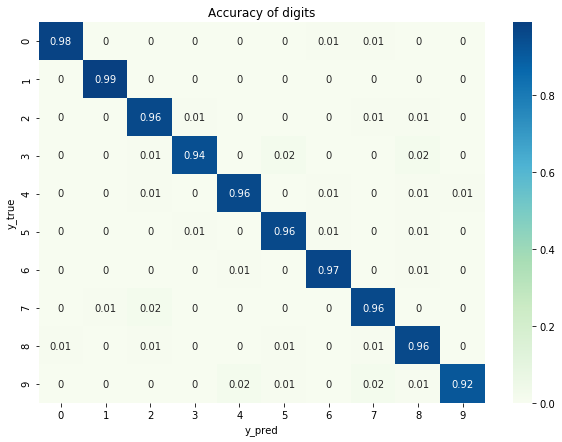

In [84]:
# 正解ラベル
labels = np.unique(y_test_MN)

# 混同行列
cmx = confusion_matrix(y_test_MN, y_pred_MN)
df = pd.DataFrame(cmx, index=labels, columns=labels)

# 混同行列の値を正解率（accuracy）に変換
df = df.apply(lambda x: round(x/sum(x), 2), axis=1)

# 混同行列をヒートマップで可視化
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, cmap="GnBu")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Accuracy of digits")
plt.show()

- いずれのクラスについても正解率90%超であり、高い精度を実現できている。

### Take away

TensorFlowを利用した所感としては、ディープニューラルネットワークのスクラッチ実装のように、各レイヤーを順次重ねていく構造となっており、直感的に理解しやすい。

但し、placeholderの設定等、スクラッチ実装では扱わなかった点については、フレームワークを繰り返し利用しながら慣れていく他ないと思う。

<トピックス>
1. TensorFlowの全体像
    - 計算グラフの引数の型を指定する（tf.placeholder）
    - 変数を定義する（tf.Variable）
    - レイヤー（tf.matmul等）を指定する
    - 活性化関数（tf.nn.relu等)を指定し、レイヤーからの出力を受け取る（add）。
    - 損失関数、評価指標、最適化手法を選択する。
    - セッションを開始する（tf.session）


2. デバッグ
    - フレームワーク利用時には、公式ドキュメントを確認しながら、引数や利用例を参考にすると良い。